#Precipitation Prediciton

In this project we call historical weather data from the Open-Meteo API. We examine weather data from January 2020 to August 25, 2023 from a location downtown Brewster, NY. We will process the data and build a neural network to predict if there will be precipitation at a given hour based on the following variables:

-Temperature

-Relative Humidity

-Dewpoint

-Surface Pressure

-Windspeed

-Wind Direction

We develop a neural network to predict if a given hour will have precipitation or not. The neural network has a concerning false negative rate. However, with the addition of the cloudcover_low variable, our false positive rate decreases from 58.18% to 35.41% and our model's accuracy on test data jumps to 90.21% from 87.75%.

In [1]:
#import relevate libraries
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

First we must call the data from the API. This URL was generated on the Open-Meteo website and will return the weather data for (41.3973,-73.6171), near downtown Brewster, from January 1, 2020 to August 25, 2023.

In [2]:
url='https://archive-api.open-meteo.com/v1/archive?latitude=41.3973&longitude=-73.6171&start_date=2020-01-01&end_date=2023-08-26&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,precipitation,surface_pressure,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch&timezone=America%2FNew_York'
response = requests.get(url)
response = response.json()

We want the hourly data from this JSON so we put the 'hourly' labels into a dataframe and drop NaN rows.

In [3]:
#%% put the relevant data in a dataframe
df=pd.DataFrame.from_dict(response['hourly'])
#%% drop NAN rows
df=df.dropna()
df['time']=pd.to_datetime(df['time'])

The column 'precipitation' currently is a float with a minimum of 0.0 and maximum of 0.768. We want to create a new dataframe called 'precip_labels' which will have a 0 if there is a 0 in the precipitation column and a 1 otherwise.

In [4]:
df['precipitation'].describe()

count    31988.000000
mean         0.005746
std          0.022715
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.768000
Name: precipitation, dtype: float64

In [5]:
def determine_precip(cell):
    if cell==0:
        return 0
    else:
        return 1

We also drop the columns 'precipitation', 'time', 'cloudcover_low', 'cloudcover_mid', and  'cloudcover_high' from precip. The model cannot intake date time data, and I chose not to use time of day or month as a variable. Furthermore, I chose not to use any of the cloud cover variables in the model because I was concerned that it was making the model too accurate and realistically, I wanted the type of a model you could feed data from a simple weather station.



In [6]:
precip_labels=df['precipitation'].apply(determine_precip)
precip=df.drop(columns=['precipitation','time','cloudcover_low', 'cloudcover_mid','cloudcover_high'])

Next we normalize the data and perform a train test split

In [19]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(precip)

In [20]:
precip_train, precip_test, labels_train, labels_test=train_test_split(
    X, precip_labels, test_size=0.2, random_state=42)


#Model Construction
Next we construct the model. For the model arcitecture I used a simple stack of two relu dense layers with 16 channels followed by a sigmoid layer. Since we are doing binary classification the final layer has one channel. This is following the arcitecture used in *Deep Learning with Python* when performing binary classification on whether an IBDM review is positive or negative.

In [43]:
model = keras.Sequential([
layers.Dense(16, activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])

We create validating data so we can plot training and validation accuracy and loss over epochs to determine if overfitting is occuring. Then we train the model.

In [44]:
partial_x_train,x_val, partial_y_train, y_val, =train_test_split(precip_train, labels_train, test_size=.4, random_state=42)

In [45]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=30,
batch_size=128,
validation_data=(x_val, y_val))


Epoch 1/30
120/120 [==============================] - 1s 4ms/step - loss: 0.3954 - accuracy: 0.8376 - val_loss: 0.3473 - val_accuracy: 0.8579
Epoch 2/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8606 - val_loss: 0.3312 - val_accuracy: 0.8669
Epoch 3/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 0.8673 - val_loss: 0.3256 - val_accuracy: 0.8701
Epoch 4/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3229 - accuracy: 0.8685 - val_loss: 0.3214 - val_accuracy: 0.8704
Epoch 5/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3192 - accuracy: 0.8692 - val_loss: 0.3190 - val_accuracy: 0.8726
Epoch 6/30
120/120 [==============================] - 0s 2ms/step - loss: 0.3166 - accuracy: 0.8718 - val_loss: 0.3166 - val_accuracy: 0.8728
Epoch 7/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3144 - accuracy: 0.8727 - val_loss: 0.3150 - val_accuracy: 0.8724
Epoch 

Now we plot Training and Validation loss and accuracy

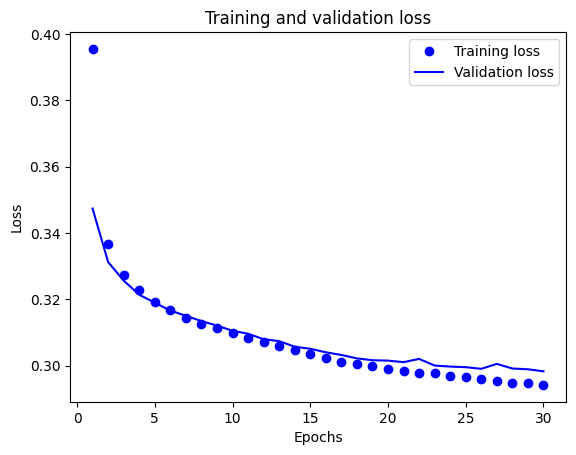

In [46]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

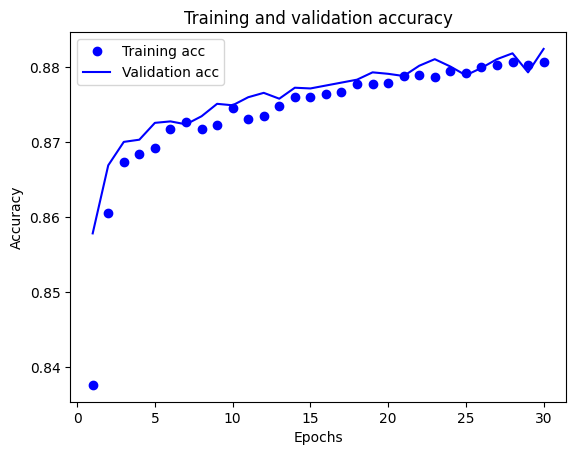

In [47]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Thought the training and validating accuracies are both continuing to rise, there is a slight bifurcation of the training and validation loss around the fifteenth epoch.  As such, we now train the model on the full training data for fifteen epochs.

In [48]:
model = keras.Sequential([
layers.Dense(16, activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])

In [49]:
model.fit(precip_train, labels_train, epochs=15, batch_size=128)

Epoch 1/15
200/200 [==============================] - 2s 4ms/step - loss: 0.3759 - accuracy: 0.8335
Epoch 2/15
200/200 [==============================] - 1s 5ms/step - loss: 0.3355 - accuracy: 0.8552
Epoch 3/15
200/200 [==============================] - 1s 7ms/step - loss: 0.3221 - accuracy: 0.8683
Epoch 4/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3146 - accuracy: 0.8698
Epoch 5/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3101 - accuracy: 0.8713
Epoch 6/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3070 - accuracy: 0.8733
Epoch 7/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8742
Epoch 8/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8755
Epoch 9/15
200/200 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8751
Epoch 10/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2996 - accuracy: 0.8771

We now determine test accuracy against this model. We find a test accuracy of 87.77%, which is very close to the training accuracy of 88.06% which indicates a model which is pretty robust when confronted with new data.

In [50]:
test_lose, test_acc=model.evaluate(precip_test,labels_test)
print(f"test_acc:{test_acc}")

200/200 [==============================] - 1s 2ms/step - loss: 0.2936 - accuracy: 0.8775
test_acc:0.8774617314338684


Here we have the model make predictions for the precipitation probablities for the test data. We make a binary array pred_labels which returns a 0 if the probability of precipitation is less than 50% and 1 otherwise

In [51]:
def prob_prec(cell):
    if cell<.5:
        return 0
    else:
        return 1

In [52]:
predictions= model.predict(precip_test)
pred_labels=np.vectorize(prob_prec)(predictions)

200/200 [==============================] - 0s 1ms/step


In [53]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='d', ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['No precipitation', 'precipitation']); ax.yaxis.set_ticklabels(['No precipitation', 'precipitation'])
    plt.show()


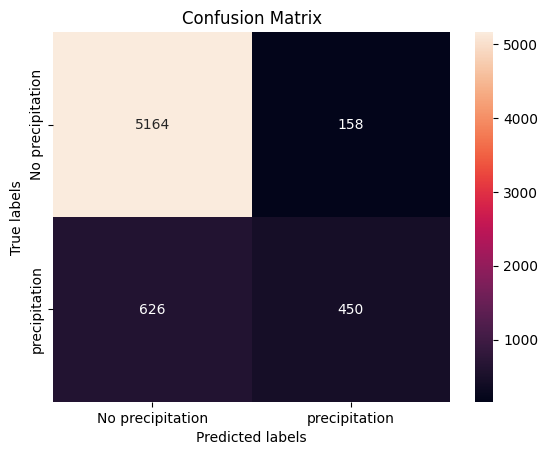

In [54]:
plot_confusion_matrix(labels_test,pred_labels)

From the confusion matrix we can see that the model accuracy is largely an artifact of having many more hours with no precipitation than with. The model is 96.7% accurate at identifying no precipitation hours but only 41.82% accurate at identifying precipitation hours. This large false negative rate is a bit of a concern.

Let's examine the model if we allow it to consider the cloud cover data as well.We'll only allow the cloudcover_low column as this is a believable observation a human could make.

In [55]:
precip1=df.drop(columns=['precipitation','time','cloudcover_low'])

we again normalize the data and perform a train test split

In [56]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(precip1)
precip_train, precip_test, labels_train, labels_test=train_test_split(
    X, precip_labels, test_size=0.2, random_state=42)

We will use the same model and end at 10 epochs as we did initially.

In [57]:
model = keras.Sequential([
layers.Dense(16, activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])

In [58]:
model.fit(precip_train, labels_train, epochs=15, batch_size=128)

Epoch 1/15
200/200 [==============================] - 2s 3ms/step - loss: 0.3238 - accuracy: 0.8721
Epoch 2/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2445 - accuracy: 0.8943
Epoch 3/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.8969
Epoch 4/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2332 - accuracy: 0.8981
Epoch 5/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2304 - accuracy: 0.8996
Epoch 6/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2286 - accuracy: 0.9000
Epoch 7/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2270 - accuracy: 0.9007
Epoch 8/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.9009
Epoch 9/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2250 - accuracy: 0.9017
Epoch 10/15
200/200 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9021

In [59]:
test_lose, test_acc=model.evaluate(precip_test,labels_test)
print(f"test_acc:{test_acc}")


200/200 [==============================] - 0s 1ms/step - loss: 0.2188 - accuracy: 0.9022
test_acc:0.9021569490432739


With this additional variable we see a 90.38% training accuracy and a 90.21% test accuracy

In [60]:
def prob_prec(cell):
    if cell<.5:
        return 0
    else:
        return 1

In [61]:
predictions= model.predict(precip_test)
pred_labels=np.vectorize(prob_prec)(predictions)

200/200 [==============================] - 0s 1ms/step


In [62]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='d', ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['No precipitation', 'precipitation']); ax.yaxis.set_ticklabels(['No precipitation', 'precipitation'])
    plt.show()


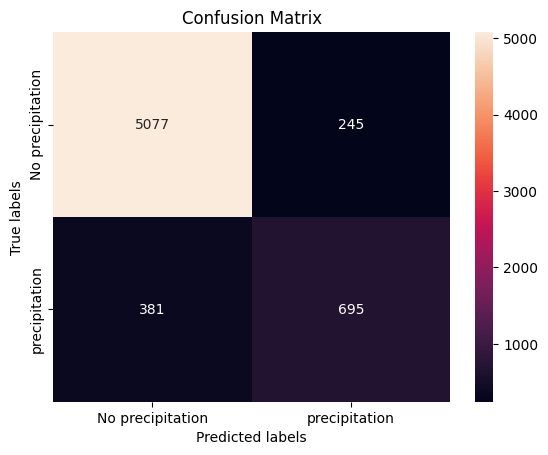

In [63]:
plot_confusion_matrix(labels_test,pred_labels)

As we can see the addition of the cloudcover_low variable is a great asset to this model. Our accuracy has increased by 2% but our false negative rate has decreased from 58.18% to 35.41%, a remarkable improvement!